In [ ]:
# Copyright 2023, Acadential, All rights reserved.

# 10-7. PyTorch로 구현해보는 Regularisation

Regularization으로 저희는 overfitting을 방지할 수 있습니다. \
저희가 살펴보았던 Regularization 방법은 다음과 같습니다:
1. L1 Regularization
2. L2 Regularization
3. Weight Decay
4. Dropout
5. Early Stopping

In [66]:
import os 

# matplotlib for plotting
import matplotlib.pyplot as plt

# Importing the dataloaders
from src.data import get_dataloaders

from tqdm import tqdm

import torch 
from torch import nn


In [67]:
train_dataloader, test_dataloader = get_dataloaders()

# L1 Regularization

L1 Regularization은 다음과 같은 식으로 정의됩니다.
$$
\hat{L}(y, \hat{y}; W) = L(y, \hat{y}; W) + \alpha \| W \|_1
$$

여기서 $W$ 은 모델의 Weight parameter들입니다.\
따라서 L1 Regularization의 항을 계산하기 위해서는 Model의 Weight parameter 값들이 필요합니다.
 

In [68]:
# Initiate model
# Section 9에서 만들어보았던 Neural Network를 사용해봅시다.

from src.model import NeuralNetwork

model = NeuralNetwork()

모델의 Weight parameter들은 ```model.parameters()``` 메서드로 불러올 수 있습니다.

In [69]:
model.parameters()

<generator object Module.parameters at 0x17205ab30>

In [70]:
# L1 Loss에 대한 구현

def L1Loss(model, alpha=1e-5):
    l1_loss = sum([p.abs().sum() for p in model.parameters()])
    return l1_loss * alpha


In [71]:
l1_loss = L1Loss(model)
print(l1_loss)

tensor(0.0312, grad_fn=<MulBackward0>)


In [72]:
# Training Loop에서 L1 Regularization 적용하기
def train_loop(model, train_dataloader, loss_fn, optimizer):
    train_loss_history = []
    tbar = tqdm(train_dataloader)
    model.train()

    for batch, label in tbar:
        pred = model(batch)
        loss = loss_fn(pred, label) + L1Loss(model, alpha=0.001)  # 기존의 Loss에 L1Loss를 더해줍니다.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tbar.set_description(f"Train Loss: {loss.item():.4f}")
        train_loss_history.append(loss.item())

    return train_loss_history

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001)
train_loss_history = train_loop(model, train_dataloader, loss_fn, optimizer)

Train Loss: 5.2760: 100%|██████████| 938/938 [00:03<00:00, 273.18it/s]


# L2 Regularization

L2 Regularization은 다음과 같은 식으로 정의됩니다.
$$
\hat{L}(y, \hat{y}; W) = L(y, \hat{y}; W) + \alpha \| W \|_2^2
$$
 

In [75]:
# L2 Loss에 대한 구현

def L2Loss(model, alpha=1e-5):
    l2_loss = sum([p.pow(2.0).sum() for p in model.parameters()])
    return l2_loss * alpha


In [76]:
l2_loss = L2Loss(model)
print(l2_loss)

tensor(0.0009, grad_fn=<MulBackward0>)


In [77]:
# Training Loop에서 L2 Regularization 적용하기
def train_loop(model, train_dataloader, loss_fn, optimizer):
    train_loss_history = []
    tbar = tqdm(train_dataloader)
    model.train()

    for batch, label in tbar:
        pred = model(batch)
        loss = loss_fn(pred, label) + L2Loss(model, alpha=0.001)  # 기존의 Loss에 L2Loss를 더해줍니다.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tbar.set_description(f"Train Loss: {loss.item():.4f}")
        train_loss_history.append(loss.item())

    return train_loss_history

In [78]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001)
train_loss_history = train_loop(model, train_dataloader, loss_fn, optimizer)

Train Loss: 2.3838: 100%|██████████| 938/938 [00:03<00:00, 279.56it/s]


# Weight Decay

Weight Decay은 다음과 같은 형태로 Weight을 Update합니다.

$$
W_t = W_{t-1} - \nabla_W L_{CE}  - \gamma \cdot \lambda \cdot W_{t-1}
$$

다행히도 Weight Decay은 PyTorch에서 매우 쉽게 구현할 수 있고, `torch.optim.SGD`에서 제공하는 `weight_decay` 파라미터를 설정해주면 됩니다.



In [79]:
import torch 

In [80]:
weight_decay = 0.001
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            weight_decay=weight_decay)  # Weight decay은 이렇게 명시할 수 있다.


# Dropout

Dropout이란 뉴럴넷을 학습시킬때, p의 확률로 일부의 neuron들을 비활성화시키는 방법입니다. \
Dropout은 Neural Network의 Layer 사이사이에 위치합니다. \
```torch.nn.Dropout``` 으로 구현됩니다.

아래와 같이 Dropout을 각 Activation function 뒤에 각 Layer마다 적용해줍니다.


In [81]:
import torch
from torch import nn


# 위 방법처럼도 구현할 수 있으나, 더 간단하게 nn.Sequential로 구현할 수 있다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Neural Network을 구성하는 layer들을
        # initialize하는 부분
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 784 // 4),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout
            nn.Linear(784 // 4, 784 // 16),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout
            nn.Linear(784 // 16, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Neural Network의 forward pass을 정의하는 부분
        # x은 input tensor
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x


In [82]:
model_with_dropout = NeuralNetwork()

In [83]:
model_with_dropout

NeuralNetwork(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=196, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=196, out_features=49, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=49, out_features=10, bias=True)
    (7): Sigmoid()
  )
)

# Early Stopping

Early Stopping이란 Validation loss가 증가하기 시작할때 학습을 중단하는 방법입니다. \
이것은 Training, Validation loop에서 구현해보도록 하겠습니다. \
Section 9에서 구현해보았던 training, validation loop 코드를 참고해서 Early Stopping을 구현해보겠습니다.

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001)
train_loss_history = []
test_loss_history = []
test_acc_history = []
epochs = 1000
best_acc = 0.
os.makedirs("checkpoints", exist_ok=True)

In [86]:
class EarlyStopping:
    def __init__(self, n_patience=5) -> None:
        self.n_patience = n_patience
        self.loss_history = []
        
    def __call__(self, loss: float):
        """Early stopping call function

        Args:
            loss (float): test loss function

        Returns:
            bool: False if early stopping condition is not met, True otherwise.
        """
        if len(self.loss_history) < self.n_patience:
            early_stop_flag = False
        elif min(self.loss_history[-self.n_patience:]) <= loss:
            # Early stopping condition is met
            # Current loss value is higher than the lowest loss value in the last n_patience epochs.
            early_stop_flag = True
        else:
            early_stop_flag = False
        
        self.loss_history.append(loss)
        return early_stop_flag
        

In [87]:
n_patience = 3
early_stopping = EarlyStopping(n_patience=n_patience)

for epoch in range(epochs):
    print(f"------------------Epoch {epoch} Train------------------")
    train_losses = train_loop(model, train_dataloader, loss_fn, optimizer)
    train_loss_history.extend(train_losses)
    print(f"------------------Epoch {epoch} Test------------------")
    test_loss, test_acc = val_loop(model, test_dataloader, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "checkpoints/best_model.pt")
    early_stop_flag = early_stopping(test_loss)
    if early_stop_flag:
        print("Early Stopping!")
        break
    
    

------------------Epoch 0 Train------------------


Train Loss: 2.3771: 100%|██████████| 938/938 [00:03<00:00, 257.35it/s]


------------------Epoch 0 Test------------------


Test Loss: 2.3049: 100%|██████████| 157/157 [00:01<00:00, 114.54it/s]


------------------Epoch 1 Train------------------


Train Loss: 2.3802: 100%|██████████| 938/938 [00:03<00:00, 249.04it/s]


------------------Epoch 1 Test------------------


Test Loss: 2.3026: 100%|██████████| 157/157 [00:01<00:00, 111.62it/s]


------------------Epoch 2 Train------------------


Train Loss: 2.3860: 100%|██████████| 938/938 [00:03<00:00, 260.00it/s]


------------------Epoch 2 Test------------------


Test Loss: 2.3002: 100%|██████████| 157/157 [00:01<00:00, 121.10it/s]


------------------Epoch 3 Train------------------


Train Loss: 2.3767: 100%|██████████| 938/938 [00:03<00:00, 271.83it/s]


------------------Epoch 3 Test------------------


Test Loss: 2.2974: 100%|██████████| 157/157 [00:01<00:00, 119.93it/s]


------------------Epoch 4 Train------------------


Train Loss: 2.3652: 100%|██████████| 938/938 [00:03<00:00, 270.60it/s]


------------------Epoch 4 Test------------------


Test Loss: 2.2942: 100%|██████████| 157/157 [00:01<00:00, 116.96it/s]


------------------Epoch 5 Train------------------


Train Loss: 2.3704: 100%|██████████| 938/938 [00:03<00:00, 258.11it/s]


------------------Epoch 5 Test------------------


Test Loss: 2.2906: 100%|██████████| 157/157 [00:01<00:00, 120.37it/s]


------------------Epoch 6 Train------------------


Train Loss: 2.3660: 100%|██████████| 938/938 [00:03<00:00, 267.45it/s]


------------------Epoch 6 Test------------------


Test Loss: 2.2868: 100%|██████████| 157/157 [00:01<00:00, 115.56it/s]


------------------Epoch 7 Train------------------


Train Loss: 2.3607: 100%|██████████| 938/938 [00:03<00:00, 258.24it/s]


------------------Epoch 7 Test------------------


Test Loss: 2.2826: 100%|██████████| 157/157 [00:01<00:00, 117.74it/s]


------------------Epoch 8 Train------------------


Train Loss: 2.3567: 100%|██████████| 938/938 [00:03<00:00, 250.89it/s]


------------------Epoch 8 Test------------------


Test Loss: 2.2780: 100%|██████████| 157/157 [00:01<00:00, 115.70it/s]


------------------Epoch 9 Train------------------


Train Loss: 2.3603: 100%|██████████| 938/938 [00:03<00:00, 260.85it/s]


------------------Epoch 9 Test------------------


Test Loss: 2.2728: 100%|██████████| 157/157 [00:01<00:00, 118.01it/s]


------------------Epoch 10 Train------------------


Train Loss: 2.3420: 100%|██████████| 938/938 [00:03<00:00, 239.28it/s]


------------------Epoch 10 Test------------------


Test Loss: 2.2670: 100%|██████████| 157/157 [00:01<00:00, 110.82it/s]


------------------Epoch 11 Train------------------


Train Loss: 2.3453: 100%|██████████| 938/938 [00:03<00:00, 259.67it/s]


------------------Epoch 11 Test------------------


Test Loss: 2.2603: 100%|██████████| 157/157 [00:01<00:00, 110.36it/s]


------------------Epoch 12 Train------------------


Train Loss: 2.3388: 100%|██████████| 938/938 [00:03<00:00, 269.41it/s]


------------------Epoch 12 Test------------------


Test Loss: 2.2526: 100%|██████████| 157/157 [00:01<00:00, 119.67it/s]


------------------Epoch 13 Train------------------


Train Loss: 2.3443: 100%|██████████| 938/938 [00:03<00:00, 260.40it/s]


------------------Epoch 13 Test------------------


Test Loss: 2.2434: 100%|██████████| 157/157 [00:01<00:00, 98.82it/s] 


------------------Epoch 14 Train------------------


Train Loss: 2.3240: 100%|██████████| 938/938 [00:04<00:00, 208.58it/s]


------------------Epoch 14 Test------------------


Test Loss: 2.2329: 100%|██████████| 157/157 [00:01<00:00, 114.11it/s]


------------------Epoch 15 Train------------------


Train Loss: 2.2918: 100%|██████████| 938/938 [00:03<00:00, 259.38it/s]


------------------Epoch 15 Test------------------


Test Loss: 2.2207: 100%|██████████| 157/157 [00:01<00:00, 117.76it/s]


------------------Epoch 16 Train------------------


Train Loss: 2.2930: 100%|██████████| 938/938 [00:04<00:00, 190.97it/s]


------------------Epoch 16 Test------------------


Test Loss: 2.2069: 100%|██████████| 157/157 [00:01<00:00, 113.92it/s]


------------------Epoch 17 Train------------------


Train Loss: 2.2840: 100%|██████████| 938/938 [00:03<00:00, 250.83it/s]


------------------Epoch 17 Test------------------


Test Loss: 2.1913: 100%|██████████| 157/157 [00:01<00:00, 109.27it/s]


------------------Epoch 18 Train------------------


Train Loss: 2.2486: 100%|██████████| 938/938 [00:03<00:00, 256.56it/s]


------------------Epoch 18 Test------------------


Test Loss: 2.1736: 100%|██████████| 157/157 [00:01<00:00, 114.87it/s]


------------------Epoch 19 Train------------------


Train Loss: 2.2502: 100%|██████████| 938/938 [00:03<00:00, 247.21it/s]


------------------Epoch 19 Test------------------


Test Loss: 2.1537: 100%|██████████| 157/157 [00:01<00:00, 121.75it/s]


------------------Epoch 20 Train------------------


Train Loss: 2.2767: 100%|██████████| 938/938 [00:03<00:00, 258.25it/s]


------------------Epoch 20 Test------------------


Test Loss: 2.1315: 100%|██████████| 157/157 [00:01<00:00, 116.48it/s]


------------------Epoch 21 Train------------------


Train Loss: 2.2086: 100%|██████████| 938/938 [00:03<00:00, 246.24it/s]


------------------Epoch 21 Test------------------


Test Loss: 2.1074: 100%|██████████| 157/157 [00:01<00:00, 112.02it/s]


------------------Epoch 22 Train------------------


Train Loss: 2.1774: 100%|██████████| 938/938 [00:03<00:00, 253.91it/s]


------------------Epoch 22 Test------------------


Test Loss: 2.0816: 100%|██████████| 157/157 [00:01<00:00, 116.73it/s]


------------------Epoch 23 Train------------------


Train Loss: 2.2016: 100%|██████████| 938/938 [00:03<00:00, 264.10it/s]


------------------Epoch 23 Test------------------


Test Loss: 2.0548: 100%|██████████| 157/157 [00:01<00:00, 119.78it/s]


------------------Epoch 24 Train------------------


Train Loss: 2.1404: 100%|██████████| 938/938 [00:03<00:00, 252.74it/s]


------------------Epoch 24 Test------------------


Test Loss: 2.0282: 100%|██████████| 157/157 [00:01<00:00, 114.27it/s]


------------------Epoch 25 Train------------------


Train Loss: 2.1229: 100%|██████████| 938/938 [00:03<00:00, 247.96it/s]


------------------Epoch 25 Test------------------


Test Loss: 2.0027: 100%|██████████| 157/157 [00:01<00:00, 119.09it/s]


------------------Epoch 26 Train------------------


Train Loss: 2.0664: 100%|██████████| 938/938 [00:03<00:00, 253.15it/s]


------------------Epoch 26 Test------------------


Test Loss: 1.9788: 100%|██████████| 157/157 [00:01<00:00, 117.69it/s]


------------------Epoch 27 Train------------------


Train Loss: 2.0745: 100%|██████████| 938/938 [00:03<00:00, 257.72it/s]


------------------Epoch 27 Test------------------


Test Loss: 1.9565: 100%|██████████| 157/157 [00:01<00:00, 121.50it/s]


------------------Epoch 28 Train------------------


Train Loss: 2.0549: 100%|██████████| 938/938 [00:03<00:00, 256.77it/s]


------------------Epoch 28 Test------------------


Test Loss: 1.9365: 100%|██████████| 157/157 [00:01<00:00, 121.96it/s]


------------------Epoch 29 Train------------------


Train Loss: 2.0136: 100%|██████████| 938/938 [00:03<00:00, 278.44it/s]


------------------Epoch 29 Test------------------


Test Loss: 1.9184: 100%|██████████| 157/157 [00:01<00:00, 123.90it/s]


------------------Epoch 30 Train------------------


Train Loss: 2.0441: 100%|██████████| 938/938 [00:03<00:00, 279.15it/s]


------------------Epoch 30 Test------------------


Test Loss: 1.9018: 100%|██████████| 157/157 [00:01<00:00, 122.25it/s]


------------------Epoch 31 Train------------------


Train Loss: 2.0198: 100%|██████████| 938/938 [00:03<00:00, 280.82it/s]


------------------Epoch 31 Test------------------


Test Loss: 1.8868: 100%|██████████| 157/157 [00:01<00:00, 125.35it/s]


------------------Epoch 32 Train------------------


Train Loss: 1.9551: 100%|██████████| 938/938 [00:03<00:00, 279.44it/s]


------------------Epoch 32 Test------------------


Test Loss: 1.8735: 100%|██████████| 157/157 [00:01<00:00, 121.79it/s]


------------------Epoch 33 Train------------------


Train Loss: 1.9682: 100%|██████████| 938/938 [00:03<00:00, 283.44it/s]


------------------Epoch 33 Test------------------


Test Loss: 1.8608: 100%|██████████| 157/157 [00:01<00:00, 123.47it/s]


------------------Epoch 34 Train------------------


Train Loss: 1.9277: 100%|██████████| 938/938 [00:03<00:00, 281.25it/s]


------------------Epoch 34 Test------------------


Test Loss: 1.8499: 100%|██████████| 157/157 [00:01<00:00, 123.82it/s]


------------------Epoch 35 Train------------------


Train Loss: 1.9771: 100%|██████████| 938/938 [00:03<00:00, 278.52it/s]


------------------Epoch 35 Test------------------


Test Loss: 1.8394: 100%|██████████| 157/157 [00:01<00:00, 124.30it/s]


------------------Epoch 36 Train------------------


Train Loss: 1.9796: 100%|██████████| 938/938 [00:03<00:00, 280.63it/s]


------------------Epoch 36 Test------------------


Test Loss: 1.8301: 100%|██████████| 157/157 [00:01<00:00, 124.42it/s]


------------------Epoch 37 Train------------------


Train Loss: 2.0154: 100%|██████████| 938/938 [00:03<00:00, 283.46it/s]


------------------Epoch 37 Test------------------


Test Loss: 1.8217: 100%|██████████| 157/157 [00:01<00:00, 123.66it/s]


------------------Epoch 38 Train------------------


Train Loss: 1.9334: 100%|██████████| 938/938 [00:03<00:00, 280.13it/s]


------------------Epoch 38 Test------------------


Test Loss: 1.8142: 100%|██████████| 157/157 [00:01<00:00, 124.31it/s]


------------------Epoch 39 Train------------------


Train Loss: 1.9615: 100%|██████████| 938/938 [00:03<00:00, 278.07it/s]


------------------Epoch 39 Test------------------


Test Loss: 1.8076: 100%|██████████| 157/157 [00:01<00:00, 123.15it/s]


------------------Epoch 40 Train------------------


Train Loss: 1.9826: 100%|██████████| 938/938 [00:03<00:00, 280.92it/s]


------------------Epoch 40 Test------------------


Test Loss: 1.8012: 100%|██████████| 157/157 [00:01<00:00, 123.93it/s]


------------------Epoch 41 Train------------------


Train Loss: 1.9112: 100%|██████████| 938/938 [00:03<00:00, 281.94it/s]


------------------Epoch 41 Test------------------


Test Loss: 1.7958: 100%|██████████| 157/157 [00:01<00:00, 122.80it/s]


------------------Epoch 42 Train------------------


Train Loss: 1.8927: 100%|██████████| 938/938 [00:03<00:00, 279.56it/s]


------------------Epoch 42 Test------------------


Test Loss: 1.7907: 100%|██████████| 157/157 [00:01<00:00, 123.66it/s]


------------------Epoch 43 Train------------------


Train Loss: 1.8705: 100%|██████████| 938/938 [00:03<00:00, 282.60it/s]


------------------Epoch 43 Test------------------


Test Loss: 1.7860: 100%|██████████| 157/157 [00:01<00:00, 123.59it/s]


------------------Epoch 44 Train------------------


Train Loss: 1.8845: 100%|██████████| 938/938 [00:03<00:00, 281.10it/s]


------------------Epoch 44 Test------------------


Test Loss: 1.7818: 100%|██████████| 157/157 [00:01<00:00, 120.66it/s]


------------------Epoch 45 Train------------------


Train Loss: 1.9741: 100%|██████████| 938/938 [00:03<00:00, 282.23it/s]


------------------Epoch 45 Test------------------


Test Loss: 1.7780: 100%|██████████| 157/157 [00:01<00:00, 123.06it/s]


------------------Epoch 46 Train------------------


Train Loss: 1.9032: 100%|██████████| 938/938 [02:21<00:00,  6.63it/s] 


------------------Epoch 46 Test------------------


Test Loss: 1.7745: 100%|██████████| 157/157 [00:01<00:00, 123.08it/s]


------------------Epoch 47 Train------------------


Train Loss: 1.8652: 100%|██████████| 938/938 [00:03<00:00, 263.52it/s]


------------------Epoch 47 Test------------------


Test Loss: 1.7714: 100%|██████████| 157/157 [00:01<00:00, 116.42it/s]


------------------Epoch 48 Train------------------


Train Loss: 1.9061: 100%|██████████| 938/938 [00:03<00:00, 247.54it/s]


------------------Epoch 48 Test------------------


Test Loss: 1.7681: 100%|██████████| 157/157 [00:01<00:00, 117.64it/s]


------------------Epoch 49 Train------------------


Train Loss: 1.9006: 100%|██████████| 938/938 [00:03<00:00, 263.47it/s]


------------------Epoch 49 Test------------------


Test Loss: 1.7650: 100%|██████████| 157/157 [00:01<00:00, 117.58it/s]


------------------Epoch 50 Train------------------


Train Loss: 1.8950: 100%|██████████| 938/938 [00:03<00:00, 263.73it/s]


------------------Epoch 50 Test------------------


Test Loss: 1.7623: 100%|██████████| 157/157 [00:01<00:00, 117.66it/s]


------------------Epoch 51 Train------------------


Train Loss: 1.9357: 100%|██████████| 938/938 [00:03<00:00, 268.66it/s]


------------------Epoch 51 Test------------------


Test Loss: 1.7593: 100%|██████████| 157/157 [00:01<00:00, 118.28it/s]


------------------Epoch 52 Train------------------


Train Loss: 1.8731: 100%|██████████| 938/938 [00:03<00:00, 268.80it/s]


------------------Epoch 52 Test------------------


Test Loss: 1.7563: 100%|██████████| 157/157 [00:01<00:00, 118.25it/s]


------------------Epoch 53 Train------------------


Train Loss: 1.9059: 100%|██████████| 938/938 [00:03<00:00, 263.01it/s]


------------------Epoch 53 Test------------------


Test Loss: 1.7535: 100%|██████████| 157/157 [00:01<00:00, 119.20it/s]


------------------Epoch 54 Train------------------


Train Loss: 1.8666: 100%|██████████| 938/938 [00:03<00:00, 267.16it/s]


------------------Epoch 54 Test------------------


Test Loss: 1.7506: 100%|██████████| 157/157 [00:01<00:00, 121.09it/s]


------------------Epoch 55 Train------------------


Train Loss: 1.8296: 100%|██████████| 938/938 [00:03<00:00, 269.15it/s]


------------------Epoch 55 Test------------------


Test Loss: 1.7479: 100%|██████████| 157/157 [00:01<00:00, 118.20it/s]


------------------Epoch 56 Train------------------


Train Loss: 1.8445: 100%|██████████| 938/938 [00:03<00:00, 267.53it/s]


------------------Epoch 56 Test------------------


Test Loss: 1.7452: 100%|██████████| 157/157 [00:01<00:00, 119.41it/s]


------------------Epoch 57 Train------------------


Train Loss: 1.8821: 100%|██████████| 938/938 [00:03<00:00, 266.50it/s]


------------------Epoch 57 Test------------------


Test Loss: 1.7422: 100%|██████████| 157/157 [00:01<00:00, 119.25it/s]


------------------Epoch 58 Train------------------


Train Loss: 1.9215: 100%|██████████| 938/938 [00:03<00:00, 262.46it/s]


------------------Epoch 58 Test------------------


Test Loss: 1.7390: 100%|██████████| 157/157 [00:01<00:00, 121.72it/s]


------------------Epoch 59 Train------------------


Train Loss: 1.8745: 100%|██████████| 938/938 [00:03<00:00, 267.73it/s]


------------------Epoch 59 Test------------------


Test Loss: 1.7362: 100%|██████████| 157/157 [00:01<00:00, 117.94it/s]


------------------Epoch 60 Train------------------


Train Loss: 1.7896: 100%|██████████| 938/938 [00:03<00:00, 269.21it/s]


------------------Epoch 60 Test------------------


Test Loss: 1.7333: 100%|██████████| 157/157 [00:01<00:00, 121.35it/s]


------------------Epoch 61 Train------------------


Train Loss: 1.8490: 100%|██████████| 938/938 [00:03<00:00, 264.18it/s]


------------------Epoch 61 Test------------------


Test Loss: 1.7301: 100%|██████████| 157/157 [00:01<00:00, 117.83it/s]


------------------Epoch 62 Train------------------


Train Loss: 1.8871: 100%|██████████| 938/938 [00:03<00:00, 262.14it/s]


------------------Epoch 62 Test------------------


Test Loss: 1.7267: 100%|██████████| 157/157 [00:01<00:00, 119.57it/s]


------------------Epoch 63 Train------------------


Train Loss: 1.8660: 100%|██████████| 938/938 [00:03<00:00, 265.48it/s]


------------------Epoch 63 Test------------------


Test Loss: 1.7234: 100%|██████████| 157/157 [00:01<00:00, 114.33it/s]


------------------Epoch 64 Train------------------


Train Loss: 1.8066: 100%|██████████| 938/938 [00:03<00:00, 270.34it/s]


------------------Epoch 64 Test------------------


Test Loss: 1.7200: 100%|██████████| 157/157 [00:01<00:00, 116.31it/s]


------------------Epoch 65 Train------------------


Train Loss: 1.8205: 100%|██████████| 938/938 [00:03<00:00, 266.96it/s]


------------------Epoch 65 Test------------------


Test Loss: 1.7167: 100%|██████████| 157/157 [00:01<00:00, 120.22it/s]


------------------Epoch 66 Train------------------


Train Loss: 1.8347: 100%|██████████| 938/938 [00:03<00:00, 267.43it/s]


------------------Epoch 66 Test------------------


Test Loss: 1.7133: 100%|██████████| 157/157 [00:01<00:00, 117.60it/s]


------------------Epoch 67 Train------------------


Train Loss: 1.8574: 100%|██████████| 938/938 [00:03<00:00, 262.66it/s]


------------------Epoch 67 Test------------------


Test Loss: 1.7099: 100%|██████████| 157/157 [00:01<00:00, 121.43it/s]


------------------Epoch 68 Train------------------


Train Loss: 1.8000: 100%|██████████| 938/938 [00:03<00:00, 266.48it/s]


------------------Epoch 68 Test------------------


Test Loss: 1.7066: 100%|██████████| 157/157 [00:01<00:00, 117.50it/s]


------------------Epoch 69 Train------------------


Train Loss: 1.8311: 100%|██████████| 938/938 [00:03<00:00, 266.83it/s]


------------------Epoch 69 Test------------------


Test Loss: 1.7034: 100%|██████████| 157/157 [00:01<00:00, 116.85it/s]


------------------Epoch 70 Train------------------


Train Loss: 1.8998: 100%|██████████| 938/938 [00:03<00:00, 262.34it/s]


------------------Epoch 70 Test------------------


Test Loss: 1.7005: 100%|██████████| 157/157 [00:01<00:00, 112.14it/s]


------------------Epoch 71 Train------------------


Train Loss: 1.8742: 100%|██████████| 938/938 [00:03<00:00, 249.68it/s]


------------------Epoch 71 Test------------------


Test Loss: 1.6966: 100%|██████████| 157/157 [00:01<00:00, 118.73it/s]


------------------Epoch 72 Train------------------


Train Loss: 1.8966: 100%|██████████| 938/938 [00:03<00:00, 252.83it/s]


------------------Epoch 72 Test------------------


Test Loss: 1.6934: 100%|██████████| 157/157 [00:01<00:00, 112.43it/s]


------------------Epoch 73 Train------------------


Train Loss: 1.9070: 100%|██████████| 938/938 [00:03<00:00, 244.98it/s]


------------------Epoch 73 Test------------------


Test Loss: 1.6902: 100%|██████████| 157/157 [00:01<00:00, 110.64it/s]


------------------Epoch 74 Train------------------


Train Loss: 1.8210: 100%|██████████| 938/938 [00:03<00:00, 249.15it/s]


------------------Epoch 74 Test------------------


Test Loss: 1.6868: 100%|██████████| 157/157 [00:01<00:00, 118.77it/s]


------------------Epoch 75 Train------------------


Train Loss: 1.8380: 100%|██████████| 938/938 [00:03<00:00, 246.13it/s]


------------------Epoch 75 Test------------------


Test Loss: 1.6837: 100%|██████████| 157/157 [00:01<00:00, 113.25it/s]


------------------Epoch 76 Train------------------


Train Loss: 1.8452: 100%|██████████| 938/938 [00:03<00:00, 254.77it/s]


------------------Epoch 76 Test------------------


Test Loss: 1.6805: 100%|██████████| 157/157 [00:01<00:00, 106.49it/s]


------------------Epoch 77 Train------------------


Train Loss: 1.8243: 100%|██████████| 938/938 [00:04<00:00, 226.12it/s]


------------------Epoch 77 Test------------------


Test Loss: 1.6776: 100%|██████████| 157/157 [00:01<00:00, 107.85it/s]


------------------Epoch 78 Train------------------


Train Loss: 1.7862: 100%|██████████| 938/938 [00:03<00:00, 254.75it/s]


------------------Epoch 78 Test------------------


Test Loss: 1.6741: 100%|██████████| 157/157 [00:01<00:00, 117.90it/s]


------------------Epoch 79 Train------------------


Train Loss: 1.8390: 100%|██████████| 938/938 [00:03<00:00, 262.90it/s]


------------------Epoch 79 Test------------------


Test Loss: 1.6712: 100%|██████████| 157/157 [00:01<00:00, 118.98it/s]


------------------Epoch 80 Train------------------


Train Loss: 1.8037: 100%|██████████| 938/938 [00:03<00:00, 266.16it/s]


------------------Epoch 80 Test------------------


Test Loss: 1.6687: 100%|██████████| 157/157 [00:01<00:00, 125.15it/s]


------------------Epoch 81 Train------------------


Train Loss: 1.8009: 100%|██████████| 938/938 [00:03<00:00, 263.95it/s]


------------------Epoch 81 Test------------------


Test Loss: 1.6659: 100%|██████████| 157/157 [00:01<00:00, 122.10it/s]


------------------Epoch 82 Train------------------


Train Loss: 1.7320: 100%|██████████| 938/938 [00:03<00:00, 265.12it/s]


------------------Epoch 82 Test------------------


Test Loss: 1.6626: 100%|██████████| 157/157 [00:01<00:00, 117.07it/s]


------------------Epoch 83 Train------------------


Train Loss: 1.7419: 100%|██████████| 938/938 [00:03<00:00, 264.12it/s]


------------------Epoch 83 Test------------------


Test Loss: 1.6602: 100%|██████████| 157/157 [00:01<00:00, 116.70it/s]


------------------Epoch 84 Train------------------


Train Loss: 1.8890: 100%|██████████| 938/938 [00:03<00:00, 261.79it/s]


------------------Epoch 84 Test------------------


Test Loss: 1.6572: 100%|██████████| 157/157 [00:01<00:00, 125.00it/s]


------------------Epoch 85 Train------------------


Train Loss: 1.8486: 100%|██████████| 938/938 [00:03<00:00, 264.81it/s]


------------------Epoch 85 Test------------------


Test Loss: 1.6546: 100%|██████████| 157/157 [00:01<00:00, 117.94it/s]


------------------Epoch 86 Train------------------


Train Loss: 1.8831: 100%|██████████| 938/938 [00:03<00:00, 266.00it/s]


------------------Epoch 86 Test------------------


Test Loss: 1.6521: 100%|██████████| 157/157 [00:01<00:00, 116.03it/s]


------------------Epoch 87 Train------------------


Train Loss: 1.7718: 100%|██████████| 938/938 [00:03<00:00, 265.66it/s]


------------------Epoch 87 Test------------------


Test Loss: 1.6496: 100%|██████████| 157/157 [00:01<00:00, 121.34it/s]


------------------Epoch 88 Train------------------


Train Loss: 1.7673: 100%|██████████| 938/938 [00:03<00:00, 262.22it/s]


------------------Epoch 88 Test------------------


Test Loss: 1.6471: 100%|██████████| 157/157 [00:01<00:00, 117.76it/s]


------------------Epoch 89 Train------------------


Train Loss: 1.8163: 100%|██████████| 938/938 [00:03<00:00, 250.10it/s]


------------------Epoch 89 Test------------------


Test Loss: 1.6448: 100%|██████████| 157/157 [00:01<00:00, 116.88it/s]


------------------Epoch 90 Train------------------


Train Loss: 1.8068: 100%|██████████| 938/938 [00:03<00:00, 248.70it/s]


------------------Epoch 90 Test------------------


Test Loss: 1.6421: 100%|██████████| 157/157 [00:01<00:00, 112.41it/s]


------------------Epoch 91 Train------------------


Train Loss: 1.7544: 100%|██████████| 938/938 [00:03<00:00, 258.69it/s]


------------------Epoch 91 Test------------------


Test Loss: 1.6401: 100%|██████████| 157/157 [00:01<00:00, 118.35it/s]


------------------Epoch 92 Train------------------


Train Loss: 1.7645: 100%|██████████| 938/938 [00:03<00:00, 247.54it/s]


------------------Epoch 92 Test------------------


Test Loss: 1.6381: 100%|██████████| 157/157 [00:01<00:00, 119.57it/s]


------------------Epoch 93 Train------------------


Train Loss: 1.7770: 100%|██████████| 938/938 [00:03<00:00, 246.55it/s]


------------------Epoch 93 Test------------------


Test Loss: 1.6361: 100%|██████████| 157/157 [00:01<00:00, 114.80it/s]


------------------Epoch 94 Train------------------


Train Loss: 1.8454: 100%|██████████| 938/938 [00:03<00:00, 252.30it/s]


------------------Epoch 94 Test------------------


Test Loss: 1.6340: 100%|██████████| 157/157 [00:01<00:00, 118.22it/s]


------------------Epoch 95 Train------------------


Train Loss: 1.8222: 100%|██████████| 938/938 [00:03<00:00, 259.41it/s]


------------------Epoch 95 Test------------------


Test Loss: 1.6323: 100%|██████████| 157/157 [00:01<00:00, 102.42it/s]


------------------Epoch 96 Train------------------


Train Loss: 1.8290: 100%|██████████| 938/938 [00:03<00:00, 243.13it/s]


------------------Epoch 96 Test------------------


Test Loss: 1.6298: 100%|██████████| 157/157 [00:01<00:00, 116.05it/s]


------------------Epoch 97 Train------------------


Train Loss: 1.7616: 100%|██████████| 938/938 [00:03<00:00, 258.41it/s]


------------------Epoch 97 Test------------------


Test Loss: 1.6282: 100%|██████████| 157/157 [00:01<00:00, 117.43it/s]


------------------Epoch 98 Train------------------


Train Loss: 1.7276: 100%|██████████| 938/938 [00:03<00:00, 241.32it/s]


------------------Epoch 98 Test------------------


Test Loss: 1.6267: 100%|██████████| 157/157 [00:01<00:00, 110.73it/s]


------------------Epoch 99 Train------------------


Train Loss: 1.7663: 100%|██████████| 938/938 [00:03<00:00, 255.24it/s]


------------------Epoch 99 Test------------------


Test Loss: 1.6246: 100%|██████████| 157/157 [00:01<00:00, 112.94it/s]


------------------Epoch 100 Train------------------


Train Loss: 1.8616: 100%|██████████| 938/938 [00:03<00:00, 262.86it/s]


------------------Epoch 100 Test------------------


Test Loss: 1.6228: 100%|██████████| 157/157 [00:01<00:00, 117.45it/s]


------------------Epoch 101 Train------------------


Train Loss: 1.7784: 100%|██████████| 938/938 [00:03<00:00, 237.07it/s]


------------------Epoch 101 Test------------------


Test Loss: 1.6208: 100%|██████████| 157/157 [00:01<00:00, 114.06it/s]


------------------Epoch 102 Train------------------


Train Loss: 1.8020: 100%|██████████| 938/938 [00:03<00:00, 252.73it/s]


------------------Epoch 102 Test------------------


Test Loss: 1.6190: 100%|██████████| 157/157 [00:01<00:00, 115.58it/s]


------------------Epoch 103 Train------------------


Train Loss: 1.7732: 100%|██████████| 938/938 [00:03<00:00, 259.84it/s]


------------------Epoch 103 Test------------------


Test Loss: 1.6176: 100%|██████████| 157/157 [00:01<00:00, 115.39it/s]


------------------Epoch 104 Train------------------


Train Loss: 1.8092: 100%|██████████| 938/938 [00:03<00:00, 261.65it/s]


------------------Epoch 104 Test------------------


Test Loss: 1.6157: 100%|██████████| 157/157 [00:01<00:00, 113.71it/s]


------------------Epoch 105 Train------------------


Train Loss: 1.7464: 100%|██████████| 938/938 [00:03<00:00, 246.33it/s]


------------------Epoch 105 Test------------------


Test Loss: 1.6140: 100%|██████████| 157/157 [00:01<00:00, 119.09it/s]


------------------Epoch 106 Train------------------


Train Loss: 1.7493: 100%|██████████| 938/938 [00:03<00:00, 243.93it/s]


------------------Epoch 106 Test------------------


Test Loss: 1.6122: 100%|██████████| 157/157 [00:01<00:00, 110.51it/s]


------------------Epoch 107 Train------------------


Train Loss: 1.7345: 100%|██████████| 938/938 [00:03<00:00, 245.10it/s]


------------------Epoch 107 Test------------------


Test Loss: 1.6109: 100%|██████████| 157/157 [00:01<00:00, 116.31it/s]


------------------Epoch 108 Train------------------


Train Loss: 1.7349: 100%|██████████| 938/938 [00:03<00:00, 252.25it/s]


------------------Epoch 108 Test------------------


Test Loss: 1.6094: 100%|██████████| 157/157 [00:01<00:00, 107.10it/s]


------------------Epoch 109 Train------------------


Train Loss: 1.7852: 100%|██████████| 938/938 [00:03<00:00, 242.03it/s]


------------------Epoch 109 Test------------------


Test Loss: 1.6082: 100%|██████████| 157/157 [00:01<00:00, 114.85it/s]


------------------Epoch 110 Train------------------


Train Loss: 1.7554: 100%|██████████| 938/938 [00:03<00:00, 247.13it/s]


------------------Epoch 110 Test------------------


Test Loss: 1.6069: 100%|██████████| 157/157 [00:01<00:00, 107.19it/s]


------------------Epoch 111 Train------------------


Train Loss: 1.7770: 100%|██████████| 938/938 [00:04<00:00, 222.80it/s]


------------------Epoch 111 Test------------------


Test Loss: 1.6061: 100%|██████████| 157/157 [00:01<00:00, 111.41it/s]


------------------Epoch 112 Train------------------


Train Loss: 1.7179: 100%|██████████| 938/938 [00:03<00:00, 254.07it/s]


------------------Epoch 112 Test------------------


Test Loss: 1.6043: 100%|██████████| 157/157 [00:01<00:00, 109.84it/s]


------------------Epoch 113 Train------------------


Train Loss: 1.7373: 100%|██████████| 938/938 [00:03<00:00, 254.00it/s]


------------------Epoch 113 Test------------------


Test Loss: 1.6031: 100%|██████████| 157/157 [00:01<00:00, 120.04it/s]


------------------Epoch 114 Train------------------


Train Loss: 1.7533: 100%|██████████| 938/938 [00:03<00:00, 254.84it/s]


------------------Epoch 114 Test------------------


Test Loss: 1.6015: 100%|██████████| 157/157 [00:01<00:00, 120.39it/s]


------------------Epoch 115 Train------------------


Train Loss: 1.7237: 100%|██████████| 938/938 [00:04<00:00, 227.88it/s]


------------------Epoch 115 Test------------------


Test Loss: 1.6006: 100%|██████████| 157/157 [00:01<00:00, 96.06it/s]


------------------Epoch 116 Train------------------


Train Loss: 1.7945: 100%|██████████| 938/938 [00:03<00:00, 250.11it/s]


------------------Epoch 116 Test------------------


Test Loss: 1.5997: 100%|██████████| 157/157 [00:01<00:00, 112.18it/s]


------------------Epoch 117 Train------------------


Train Loss: 1.7192: 100%|██████████| 938/938 [00:03<00:00, 254.58it/s]


------------------Epoch 117 Test------------------


Test Loss: 1.5988: 100%|██████████| 157/157 [00:01<00:00, 117.69it/s]


------------------Epoch 118 Train------------------


Train Loss: 1.7629: 100%|██████████| 938/938 [00:03<00:00, 243.65it/s]


------------------Epoch 118 Test------------------


Test Loss: 1.5977: 100%|██████████| 157/157 [00:01<00:00, 110.77it/s]


------------------Epoch 119 Train------------------


Train Loss: 1.7287: 100%|██████████| 938/938 [00:04<00:00, 232.46it/s]


------------------Epoch 119 Test------------------


Test Loss: 1.5970: 100%|██████████| 157/157 [00:01<00:00, 112.27it/s]


------------------Epoch 120 Train------------------


Train Loss: 1.7373: 100%|██████████| 938/938 [00:04<00:00, 219.32it/s]


------------------Epoch 120 Test------------------


Test Loss: 1.5957: 100%|██████████| 157/157 [00:01<00:00, 109.48it/s]


------------------Epoch 121 Train------------------


Train Loss: 1.7946: 100%|██████████| 938/938 [00:03<00:00, 241.23it/s]


------------------Epoch 121 Test------------------


Test Loss: 1.5950: 100%|██████████| 157/157 [00:01<00:00, 109.61it/s]


------------------Epoch 122 Train------------------


Train Loss: 1.7486: 100%|██████████| 938/938 [00:03<00:00, 239.68it/s]


------------------Epoch 122 Test------------------


Test Loss: 1.5942: 100%|██████████| 157/157 [00:01<00:00, 104.99it/s]


------------------Epoch 123 Train------------------


Train Loss: 1.7035: 100%|██████████| 938/938 [00:03<00:00, 247.31it/s]


------------------Epoch 123 Test------------------


Test Loss: 1.5932: 100%|██████████| 157/157 [00:01<00:00, 109.40it/s]


------------------Epoch 124 Train------------------


Train Loss: 1.7895: 100%|██████████| 938/938 [00:03<00:00, 243.47it/s]


------------------Epoch 124 Test------------------


Test Loss: 1.5923: 100%|██████████| 157/157 [00:01<00:00, 114.10it/s]


------------------Epoch 125 Train------------------


Train Loss: 1.7270: 100%|██████████| 938/938 [00:03<00:00, 254.27it/s]


------------------Epoch 125 Test------------------


Test Loss: 1.5919: 100%|██████████| 157/157 [00:01<00:00, 117.96it/s]


------------------Epoch 126 Train------------------


Train Loss: 1.7566: 100%|██████████| 938/938 [00:03<00:00, 255.14it/s]


------------------Epoch 126 Test------------------


Test Loss: 1.5909: 100%|██████████| 157/157 [00:01<00:00, 116.90it/s]


------------------Epoch 127 Train------------------


Train Loss: 1.7892: 100%|██████████| 938/938 [00:03<00:00, 258.62it/s]


------------------Epoch 127 Test------------------


Test Loss: 1.5900: 100%|██████████| 157/157 [00:01<00:00, 104.89it/s]


------------------Epoch 128 Train------------------


Train Loss: 1.7812: 100%|██████████| 938/938 [00:03<00:00, 249.11it/s]


------------------Epoch 128 Test------------------


Test Loss: 1.5891: 100%|██████████| 157/157 [00:01<00:00, 114.72it/s]


------------------Epoch 129 Train------------------


Train Loss: 1.7438: 100%|██████████| 938/938 [00:03<00:00, 270.32it/s]


------------------Epoch 129 Test------------------


Test Loss: 1.5888: 100%|██████████| 157/157 [00:01<00:00, 118.57it/s]


------------------Epoch 130 Train------------------


Train Loss: 1.7027: 100%|██████████| 938/938 [00:03<00:00, 265.23it/s]


------------------Epoch 130 Test------------------


Test Loss: 1.5882: 100%|██████████| 157/157 [00:01<00:00, 118.52it/s]


------------------Epoch 131 Train------------------


Train Loss: 1.7906: 100%|██████████| 938/938 [00:03<00:00, 242.71it/s]


------------------Epoch 131 Test------------------


Test Loss: 1.5873: 100%|██████████| 157/157 [00:01<00:00, 115.51it/s]


------------------Epoch 132 Train------------------


Train Loss: 1.7066: 100%|██████████| 938/938 [00:03<00:00, 259.64it/s]


------------------Epoch 132 Test------------------


Test Loss: 1.5871: 100%|██████████| 157/157 [00:01<00:00, 122.98it/s]


------------------Epoch 133 Train------------------


Train Loss: 1.7346: 100%|██████████| 938/938 [00:03<00:00, 261.02it/s]


------------------Epoch 133 Test------------------


Test Loss: 1.5867: 100%|██████████| 157/157 [00:01<00:00, 120.83it/s]


------------------Epoch 134 Train------------------


Train Loss: 1.7347: 100%|██████████| 938/938 [00:03<00:00, 237.28it/s]


------------------Epoch 134 Test------------------


Test Loss: 1.5861: 100%|██████████| 157/157 [00:01<00:00, 114.30it/s]


------------------Epoch 135 Train------------------


Train Loss: 1.7347: 100%|██████████| 938/938 [00:03<00:00, 275.03it/s]


------------------Epoch 135 Test------------------


Test Loss: 1.5854: 100%|██████████| 157/157 [00:01<00:00, 108.03it/s]


------------------Epoch 136 Train------------------


Train Loss: 1.7890: 100%|██████████| 938/938 [00:03<00:00, 260.59it/s]


------------------Epoch 136 Test------------------


Test Loss: 1.5847: 100%|██████████| 157/157 [00:01<00:00, 116.59it/s]


------------------Epoch 137 Train------------------


Train Loss: 1.7600: 100%|██████████| 938/938 [00:03<00:00, 257.67it/s]


------------------Epoch 137 Test------------------


Test Loss: 1.5844: 100%|██████████| 157/157 [00:01<00:00, 117.37it/s]


------------------Epoch 138 Train------------------


Train Loss: 1.7915: 100%|██████████| 938/938 [00:03<00:00, 267.37it/s]


------------------Epoch 138 Test------------------


Test Loss: 1.5838: 100%|██████████| 157/157 [00:01<00:00, 118.49it/s]


------------------Epoch 139 Train------------------


Train Loss: 1.7289: 100%|██████████| 938/938 [00:03<00:00, 275.75it/s]


------------------Epoch 139 Test------------------


Test Loss: 1.5830: 100%|██████████| 157/157 [00:01<00:00, 121.57it/s]


------------------Epoch 140 Train------------------


Train Loss: 1.7635: 100%|██████████| 938/938 [00:03<00:00, 281.90it/s]


------------------Epoch 140 Test------------------


Test Loss: 1.5826: 100%|██████████| 157/157 [00:01<00:00, 123.74it/s]


------------------Epoch 141 Train------------------


Train Loss: 1.6793: 100%|██████████| 938/938 [00:03<00:00, 275.25it/s]


------------------Epoch 141 Test------------------


Test Loss: 1.5822: 100%|██████████| 157/157 [00:01<00:00, 115.80it/s]


------------------Epoch 142 Train------------------


Train Loss: 1.7822: 100%|██████████| 938/938 [00:03<00:00, 261.01it/s]


------------------Epoch 142 Test------------------


Test Loss: 1.5821: 100%|██████████| 157/157 [00:01<00:00, 117.97it/s]


------------------Epoch 143 Train------------------


Train Loss: 1.6891: 100%|██████████| 938/938 [00:03<00:00, 256.25it/s]


------------------Epoch 143 Test------------------


Test Loss: 1.5811: 100%|██████████| 157/157 [00:01<00:00, 117.13it/s]


------------------Epoch 144 Train------------------


Train Loss: 1.7204: 100%|██████████| 938/938 [00:03<00:00, 265.50it/s]


------------------Epoch 144 Test------------------


Test Loss: 1.5805: 100%|██████████| 157/157 [00:01<00:00, 121.50it/s]


------------------Epoch 145 Train------------------


Train Loss: 1.7344: 100%|██████████| 938/938 [00:03<00:00, 269.45it/s]


------------------Epoch 145 Test------------------


Test Loss: 1.5805: 100%|██████████| 157/157 [00:01<00:00, 113.48it/s]


------------------Epoch 146 Train------------------


Train Loss: 1.7189: 100%|██████████| 938/938 [00:03<00:00, 266.28it/s]


------------------Epoch 146 Test------------------


Test Loss: 1.5798: 100%|██████████| 157/157 [00:01<00:00, 114.62it/s]


------------------Epoch 147 Train------------------


Train Loss: 1.7254: 100%|██████████| 938/938 [00:03<00:00, 257.89it/s]


------------------Epoch 147 Test------------------


Test Loss: 1.5791: 100%|██████████| 157/157 [00:01<00:00, 118.04it/s]


------------------Epoch 148 Train------------------


Train Loss: 1.6784: 100%|██████████| 938/938 [00:03<00:00, 266.76it/s]


------------------Epoch 148 Test------------------


Test Loss: 1.5787: 100%|██████████| 157/157 [00:01<00:00, 115.28it/s]


------------------Epoch 149 Train------------------


Train Loss: 1.7411: 100%|██████████| 938/938 [00:03<00:00, 258.16it/s]


------------------Epoch 149 Test------------------


Test Loss: 1.5789: 100%|██████████| 157/157 [00:01<00:00, 114.36it/s]


------------------Epoch 150 Train------------------


Train Loss: 1.8339: 100%|██████████| 938/938 [00:03<00:00, 258.19it/s]


------------------Epoch 150 Test------------------


Test Loss: 1.5781: 100%|██████████| 157/157 [00:01<00:00, 104.36it/s]


------------------Epoch 151 Train------------------


Train Loss: 1.7171: 100%|██████████| 938/938 [00:03<00:00, 251.13it/s]


------------------Epoch 151 Test------------------


Test Loss: 1.5776: 100%|██████████| 157/157 [00:01<00:00, 114.05it/s]


------------------Epoch 152 Train------------------


Train Loss: 1.7221: 100%|██████████| 938/938 [00:03<00:00, 250.94it/s]


------------------Epoch 152 Test------------------


Test Loss: 1.5766: 100%|██████████| 157/157 [00:01<00:00, 112.07it/s]


------------------Epoch 153 Train------------------


Train Loss: 1.7144: 100%|██████████| 938/938 [00:03<00:00, 269.06it/s]


------------------Epoch 153 Test------------------


Test Loss: 1.5768: 100%|██████████| 157/157 [00:01<00:00, 119.97it/s]


------------------Epoch 154 Train------------------


Train Loss: 1.7556: 100%|██████████| 938/938 [00:03<00:00, 268.33it/s]


------------------Epoch 154 Test------------------


Test Loss: 1.5764: 100%|██████████| 157/157 [00:01<00:00, 113.41it/s]


------------------Epoch 155 Train------------------


Train Loss: 1.7450: 100%|██████████| 938/938 [00:03<00:00, 269.66it/s]


------------------Epoch 155 Test------------------


Test Loss: 1.5758: 100%|██████████| 157/157 [00:01<00:00, 119.57it/s]


------------------Epoch 156 Train------------------


Train Loss: 1.7173: 100%|██████████| 938/938 [00:03<00:00, 273.96it/s]


------------------Epoch 156 Test------------------


Test Loss: 1.5752: 100%|██████████| 157/157 [00:01<00:00, 115.69it/s]


------------------Epoch 157 Train------------------


Train Loss: 1.7844: 100%|██████████| 938/938 [00:03<00:00, 261.03it/s]


------------------Epoch 157 Test------------------


Test Loss: 1.5750: 100%|██████████| 157/157 [00:01<00:00, 108.31it/s]


------------------Epoch 158 Train------------------


Train Loss: 1.6837: 100%|██████████| 938/938 [00:03<00:00, 270.38it/s]


------------------Epoch 158 Test------------------


Test Loss: 1.5743: 100%|██████████| 157/157 [00:01<00:00, 120.94it/s]


------------------Epoch 159 Train------------------


Train Loss: 1.7474: 100%|██████████| 938/938 [00:03<00:00, 266.62it/s]


------------------Epoch 159 Test------------------


Test Loss: 1.5743: 100%|██████████| 157/157 [00:01<00:00, 111.40it/s]


------------------Epoch 160 Train------------------


Train Loss: 1.6853: 100%|██████████| 938/938 [00:03<00:00, 270.66it/s]


------------------Epoch 160 Test------------------


Test Loss: 1.5733: 100%|██████████| 157/157 [00:01<00:00, 117.84it/s]


------------------Epoch 161 Train------------------


Train Loss: 1.7168: 100%|██████████| 938/938 [00:03<00:00, 270.70it/s]


------------------Epoch 161 Test------------------


Test Loss: 1.5726: 100%|██████████| 157/157 [00:01<00:00, 113.51it/s]


------------------Epoch 162 Train------------------


Train Loss: 1.8332: 100%|██████████| 938/938 [00:03<00:00, 278.13it/s]


------------------Epoch 162 Test------------------


Test Loss: 1.5723: 100%|██████████| 157/157 [00:01<00:00, 120.31it/s]


------------------Epoch 163 Train------------------


Train Loss: 1.7354: 100%|██████████| 938/938 [00:03<00:00, 275.96it/s]


------------------Epoch 163 Test------------------


Test Loss: 1.5717: 100%|██████████| 157/157 [00:01<00:00, 123.09it/s]


------------------Epoch 164 Train------------------


Train Loss: 1.6929: 100%|██████████| 938/938 [00:03<00:00, 271.42it/s]


------------------Epoch 164 Test------------------


Test Loss: 1.5711: 100%|██████████| 157/157 [00:01<00:00, 118.49it/s]


------------------Epoch 165 Train------------------


Train Loss: 1.7180: 100%|██████████| 938/938 [00:03<00:00, 249.53it/s]


------------------Epoch 165 Test------------------


Test Loss: 1.5710: 100%|██████████| 157/157 [00:01<00:00, 111.78it/s]


------------------Epoch 166 Train------------------


Train Loss: 1.7327: 100%|██████████| 938/938 [00:03<00:00, 246.90it/s]


------------------Epoch 166 Test------------------


Test Loss: 1.5701: 100%|██████████| 157/157 [00:01<00:00, 122.18it/s]


------------------Epoch 167 Train------------------


Train Loss: 1.6989: 100%|██████████| 938/938 [00:03<00:00, 274.62it/s]


------------------Epoch 167 Test------------------


Test Loss: 1.5698: 100%|██████████| 157/157 [00:01<00:00, 117.44it/s]


------------------Epoch 168 Train------------------


Train Loss: 1.7379: 100%|██████████| 938/938 [00:03<00:00, 269.56it/s]


------------------Epoch 168 Test------------------


Test Loss: 1.5697: 100%|██████████| 157/157 [00:01<00:00, 122.25it/s]


------------------Epoch 169 Train------------------


Train Loss: 1.6916: 100%|██████████| 938/938 [00:03<00:00, 270.87it/s]


------------------Epoch 169 Test------------------


Test Loss: 1.5688: 100%|██████████| 157/157 [00:01<00:00, 119.50it/s]


------------------Epoch 170 Train------------------


Train Loss: 1.7299: 100%|██████████| 938/938 [00:03<00:00, 251.38it/s]


------------------Epoch 170 Test------------------


Test Loss: 1.5685: 100%|██████████| 157/157 [00:01<00:00, 109.68it/s]


------------------Epoch 171 Train------------------


Train Loss: 1.6516: 100%|██████████| 938/938 [00:03<00:00, 242.58it/s]


------------------Epoch 171 Test------------------


Test Loss: 1.5680: 100%|██████████| 157/157 [00:01<00:00, 123.40it/s]


------------------Epoch 172 Train------------------


Train Loss: 1.7012: 100%|██████████| 938/938 [00:03<00:00, 265.78it/s]


------------------Epoch 172 Test------------------


Test Loss: 1.5679: 100%|██████████| 157/157 [00:01<00:00, 113.62it/s]


------------------Epoch 173 Train------------------


Train Loss: 1.7020: 100%|██████████| 938/938 [00:03<00:00, 250.43it/s]


------------------Epoch 173 Test------------------


Test Loss: 1.5672: 100%|██████████| 157/157 [00:01<00:00, 113.84it/s]


------------------Epoch 174 Train------------------


Train Loss: 1.6736: 100%|██████████| 938/938 [00:03<00:00, 264.11it/s]


------------------Epoch 174 Test------------------


Test Loss: 1.5673: 100%|██████████| 157/157 [00:01<00:00, 108.29it/s]


------------------Epoch 175 Train------------------


Train Loss: 1.6806: 100%|██████████| 938/938 [00:03<00:00, 254.51it/s]


------------------Epoch 175 Test------------------


Test Loss: 1.5659: 100%|██████████| 157/157 [00:01<00:00, 117.08it/s]


------------------Epoch 176 Train------------------


Train Loss: 1.7037: 100%|██████████| 938/938 [00:03<00:00, 273.53it/s]


------------------Epoch 176 Test------------------


Test Loss: 1.5657: 100%|██████████| 157/157 [00:01<00:00, 120.82it/s]


------------------Epoch 177 Train------------------


Train Loss: 1.7203: 100%|██████████| 938/938 [00:03<00:00, 279.52it/s]


------------------Epoch 177 Test------------------


Test Loss: 1.5655: 100%|██████████| 157/157 [00:01<00:00, 116.99it/s]


------------------Epoch 178 Train------------------


Train Loss: 1.7191: 100%|██████████| 938/938 [00:03<00:00, 262.99it/s]


------------------Epoch 178 Test------------------


Test Loss: 1.5655: 100%|██████████| 157/157 [00:01<00:00, 119.24it/s]


------------------Epoch 179 Train------------------


Train Loss: 1.6939: 100%|██████████| 938/938 [00:03<00:00, 275.11it/s]


------------------Epoch 179 Test------------------


Test Loss: 1.5646: 100%|██████████| 157/157 [00:01<00:00, 116.47it/s]


------------------Epoch 180 Train------------------


Train Loss: 1.7295: 100%|██████████| 938/938 [00:03<00:00, 258.27it/s]


------------------Epoch 180 Test------------------


Test Loss: 1.5641: 100%|██████████| 157/157 [00:01<00:00, 116.20it/s]


------------------Epoch 181 Train------------------


Train Loss: 1.6907: 100%|██████████| 938/938 [00:03<00:00, 250.86it/s]


------------------Epoch 181 Test------------------


Test Loss: 1.5635: 100%|██████████| 157/157 [00:01<00:00, 114.55it/s]


------------------Epoch 182 Train------------------


Train Loss: 1.7109: 100%|██████████| 938/938 [00:03<00:00, 259.94it/s]


------------------Epoch 182 Test------------------


Test Loss: 1.5637: 100%|██████████| 157/157 [00:01<00:00, 110.78it/s]


------------------Epoch 183 Train------------------


Train Loss: 1.7076: 100%|██████████| 938/938 [00:03<00:00, 253.94it/s]


------------------Epoch 183 Test------------------


Test Loss: 1.5630: 100%|██████████| 157/157 [00:01<00:00, 119.18it/s]


------------------Epoch 184 Train------------------


Train Loss: 1.7124: 100%|██████████| 938/938 [00:03<00:00, 256.21it/s]


------------------Epoch 184 Test------------------


Test Loss: 1.5632: 100%|██████████| 157/157 [00:01<00:00, 120.45it/s]


------------------Epoch 185 Train------------------


Train Loss: 1.6777: 100%|██████████| 938/938 [00:03<00:00, 260.69it/s]


------------------Epoch 185 Test------------------


Test Loss: 1.5623: 100%|██████████| 157/157 [00:01<00:00, 121.79it/s]


------------------Epoch 186 Train------------------


Train Loss: 1.6819: 100%|██████████| 938/938 [00:03<00:00, 266.25it/s]


------------------Epoch 186 Test------------------


Test Loss: 1.5623: 100%|██████████| 157/157 [00:01<00:00, 117.05it/s]


------------------Epoch 187 Train------------------


Train Loss: 1.7145: 100%|██████████| 938/938 [00:03<00:00, 270.05it/s]


------------------Epoch 187 Test------------------


Test Loss: 1.5622: 100%|██████████| 157/157 [00:01<00:00, 116.88it/s]


------------------Epoch 188 Train------------------


Train Loss: 1.6996: 100%|██████████| 938/938 [00:03<00:00, 268.35it/s]


------------------Epoch 188 Test------------------


Test Loss: 1.5622: 100%|██████████| 157/157 [00:01<00:00, 122.22it/s]


------------------Epoch 189 Train------------------


Train Loss: 1.7045: 100%|██████████| 938/938 [00:03<00:00, 280.28it/s]


------------------Epoch 189 Test------------------


Test Loss: 1.5615: 100%|██████████| 157/157 [00:01<00:00, 114.80it/s]


------------------Epoch 190 Train------------------


Train Loss: 1.7918: 100%|██████████| 938/938 [00:03<00:00, 267.47it/s]


------------------Epoch 190 Test------------------


Test Loss: 1.5614: 100%|██████████| 157/157 [00:01<00:00, 114.19it/s]


------------------Epoch 191 Train------------------


Train Loss: 1.6930: 100%|██████████| 938/938 [00:03<00:00, 268.12it/s]


------------------Epoch 191 Test------------------


Test Loss: 1.5612: 100%|██████████| 157/157 [00:01<00:00, 121.84it/s]


------------------Epoch 192 Train------------------


Train Loss: 1.7833: 100%|██████████| 938/938 [00:03<00:00, 260.16it/s]


------------------Epoch 192 Test------------------


Test Loss: 1.5607: 100%|██████████| 157/157 [00:01<00:00, 110.34it/s]


------------------Epoch 193 Train------------------


Train Loss: 1.6919: 100%|██████████| 938/938 [00:03<00:00, 259.34it/s]


------------------Epoch 193 Test------------------


Test Loss: 1.5606: 100%|██████████| 157/157 [00:01<00:00, 123.90it/s]


------------------Epoch 194 Train------------------


Train Loss: 1.6944: 100%|██████████| 938/938 [00:03<00:00, 270.65it/s]


------------------Epoch 194 Test------------------


Test Loss: 1.5601: 100%|██████████| 157/157 [00:01<00:00, 112.00it/s]


------------------Epoch 195 Train------------------


Train Loss: 1.6714: 100%|██████████| 938/938 [00:03<00:00, 263.41it/s]


------------------Epoch 195 Test------------------


Test Loss: 1.5604: 100%|██████████| 157/157 [00:01<00:00, 116.22it/s]


------------------Epoch 196 Train------------------


Train Loss: 1.7337: 100%|██████████| 938/938 [00:03<00:00, 256.21it/s]


------------------Epoch 196 Test------------------


Test Loss: 1.5598: 100%|██████████| 157/157 [00:01<00:00, 108.11it/s]


------------------Epoch 197 Train------------------


Train Loss: 1.7477: 100%|██████████| 938/938 [00:03<00:00, 276.81it/s]


------------------Epoch 197 Test------------------


Test Loss: 1.5596: 100%|██████████| 157/157 [00:01<00:00, 120.80it/s]


------------------Epoch 198 Train------------------


Train Loss: 1.7208: 100%|██████████| 938/938 [00:03<00:00, 280.66it/s]


------------------Epoch 198 Test------------------


Test Loss: 1.5595: 100%|██████████| 157/157 [00:01<00:00, 118.07it/s]


------------------Epoch 199 Train------------------


Train Loss: 1.6944: 100%|██████████| 938/938 [00:03<00:00, 265.15it/s]


------------------Epoch 199 Test------------------


Test Loss: 1.5594: 100%|██████████| 157/157 [00:01<00:00, 110.35it/s]


------------------Epoch 200 Train------------------


Train Loss: 1.7087: 100%|██████████| 938/938 [00:03<00:00, 248.39it/s]


------------------Epoch 200 Test------------------


Test Loss: 1.5590: 100%|██████████| 157/157 [00:01<00:00, 109.75it/s]


------------------Epoch 201 Train------------------


Train Loss: 1.7646: 100%|██████████| 938/938 [00:03<00:00, 280.66it/s]


------------------Epoch 201 Test------------------


Test Loss: 1.5589: 100%|██████████| 157/157 [00:01<00:00, 122.85it/s]


------------------Epoch 202 Train------------------


Train Loss: 1.8022: 100%|██████████| 938/938 [00:03<00:00, 278.44it/s]


------------------Epoch 202 Test------------------


Test Loss: 1.5590: 100%|██████████| 157/157 [00:01<00:00, 121.90it/s]


------------------Epoch 203 Train------------------


Train Loss: 1.7292: 100%|██████████| 938/938 [00:03<00:00, 278.23it/s]


------------------Epoch 203 Test------------------


Test Loss: 1.5588: 100%|██████████| 157/157 [00:01<00:00, 117.18it/s]


------------------Epoch 204 Train------------------


Train Loss: 1.6959: 100%|██████████| 938/938 [00:03<00:00, 250.23it/s]


------------------Epoch 204 Test------------------


Test Loss: 1.5583: 100%|██████████| 157/157 [00:01<00:00, 112.41it/s]


------------------Epoch 205 Train------------------


Train Loss: 1.6838: 100%|██████████| 938/938 [00:03<00:00, 254.08it/s]


------------------Epoch 205 Test------------------


Test Loss: 1.5582: 100%|██████████| 157/157 [00:01<00:00, 115.40it/s]


------------------Epoch 206 Train------------------


Train Loss: 1.6481: 100%|██████████| 938/938 [00:03<00:00, 277.52it/s]


------------------Epoch 206 Test------------------


Test Loss: 1.5579: 100%|██████████| 157/157 [00:01<00:00, 116.31it/s]


------------------Epoch 207 Train------------------


Train Loss: 1.6392: 100%|██████████| 938/938 [00:03<00:00, 274.81it/s]


------------------Epoch 207 Test------------------


Test Loss: 1.5579: 100%|██████████| 157/157 [00:01<00:00, 119.99it/s]


------------------Epoch 208 Train------------------


Train Loss: 1.7383: 100%|██████████| 938/938 [00:03<00:00, 277.32it/s]


------------------Epoch 208 Test------------------


Test Loss: 1.5579: 100%|██████████| 157/157 [00:01<00:00, 118.59it/s]


------------------Epoch 209 Train------------------


Train Loss: 1.7612: 100%|██████████| 938/938 [00:03<00:00, 270.44it/s]


------------------Epoch 209 Test------------------


Test Loss: 1.5574: 100%|██████████| 157/157 [00:01<00:00, 122.20it/s]


------------------Epoch 210 Train------------------


Train Loss: 1.6954: 100%|██████████| 938/938 [00:03<00:00, 264.26it/s]


------------------Epoch 210 Test------------------


Test Loss: 1.5575: 100%|██████████| 157/157 [00:01<00:00, 115.54it/s]


------------------Epoch 211 Train------------------


  0%|          | 0/938 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import os 
os.makedirs("figures", exist_ok=True)

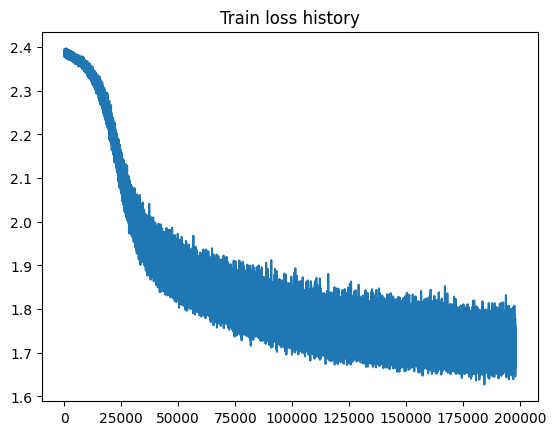

In [91]:
plt.figure()
plt.plot(train_loss_history)
plt.title('Train loss history')
plt.savefig('figures/train_loss_history.png')

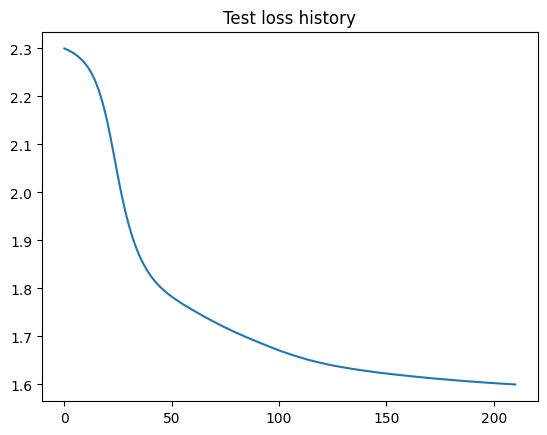

In [92]:
plt.figure()
plt.plot(test_loss_history)
plt.title('Test loss history')
plt.savefig('figures/test_loss_history.png')

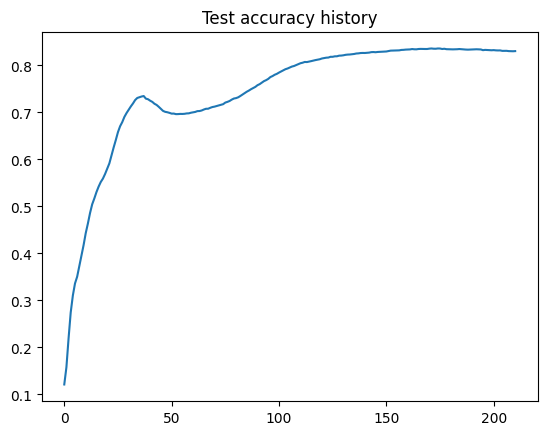

In [93]:
plt.figure()
plt.plot(test_acc_history)
plt.title('Test accuracy history')
plt.savefig('figures/test_acc_history.png')